<a href="https://colab.research.google.com/github/MSaber7/Machine-Learning/blob/master/ImageBlending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Blending

In [0]:
import sys
import os
import numpy as np
import cv2
import scipy
from scipy.stats import norm
from scipy.signal import convolve2d
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(220, 220, 3)


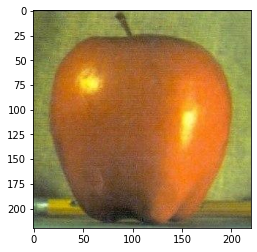

In [34]:
image1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/Data/01.jpg')
image1 = cv2.resize(image1, (220, 220))
print(image1.shape)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

(220, 220, 3)


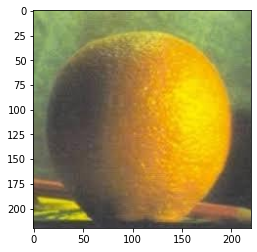

In [35]:
image2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/Data/02.jpg')
image2 = cv2.resize(image2, (220, 220))
print(image2.shape)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))


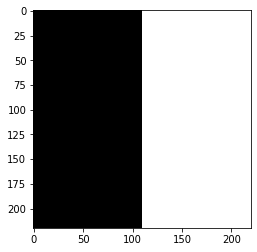

In [36]:
mask = np.zeros((220,220,3), dtype='float32')
mask.shape
mask[:,int(image2.shape[1]/2):] = 1
plt.imshow(mask)
mask = mask * 255
mask_ = cv2.imwrite("mask2.jpg", mask)


In [37]:
mask = cv2.imread("mask2.jpg")
mask.shape

(220, 220, 3)

In [0]:
import sys
import os
import numpy as np
import cv2
import scipy
from scipy.stats import norm
from scipy.signal import convolve2d
import math

In [0]:
# split rgb image to its channels
def split_rgb(image):
  red = None
  green = None
  blue = None
  (blue, green, red) = cv2.split(image)
  return red, green, blue

In [0]:
#generate a 5x5 kernel
def generating_kernel(a):
  w_1d = np.array([0.25 - a/2.0, 0.25, a, 0.25, 0.25 - a/2.0])
  return np.outer(w_1d, w_1d)

In [0]:
# reduce image by 1/2
def ireduce(image):
  out = None
  kernel = generating_kernel(0.4)
  outimage = scipy.signal.convolve2d(image,kernel,'same')
  out = outimage[::2,::2]
  return out

In [0]:
# expand image by factor of 2
def iexpand(image):
  out = None
  kernel = generating_kernel(0.4)
  outimage = np.zeros((image.shape[0]*2, image.shape[1]*2), dtype=np.float64)
  outimage[::2,::2]=image[:,:]
  out = 4*scipy.signal.convolve2d(outimage,kernel,'same')
  return out

In [0]:
# create a gaussain pyramid of a given image
def gauss_pyramid(image, levels):
  output = []
  output.append(image)
  tmp = image
  for i in range(0,levels):
    tmp = ireduce(tmp)
    output.append(tmp)
  return output

In [0]:
# build a laplacian pyramid
def lapl_pyramid(gauss_pyr):
  output = []
  k = len(gauss_pyr)
  for i in range(0,k-1):
    gu = gauss_pyr[i]
    egu = iexpand(gauss_pyr[i+1])
    if egu.shape[0] > gu.shape[0]:
       egu = np.delete(egu,(-1),axis=0)
    if egu.shape[1] > gu.shape[1]:
      egu = np.delete(egu,(-1),axis=1)
    output.append(gu - egu)
  output.append(gauss_pyr.pop())
  return output

In [0]:
# Blend the two laplacian pyramids by weighting them according to the mask.
def blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
  blended_pyr = []
  k= len(gauss_pyr_mask)
  for i in range(0,k):
   p1= gauss_pyr_mask[i]*lapl_pyr_white[i]
   p2=(1 - gauss_pyr_mask[i])*lapl_pyr_black[i]
   blended_pyr.append(p1 + p2)
  return blended_pyr

In [0]:
# Reconstruct the image based on its laplacian pyramid.
def collapse(lapl_pyr):
  output = None
  output = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
  for i in range(len(lapl_pyr)-1,0,-1):
    lap = iexpand(lapl_pyr[i])
    lapb = lapl_pyr[i-1]
    if lap.shape[0] > lapb.shape[0]:
      lap = np.delete(lap,(-1),axis=0)
    if lap.shape[1] > lapb.shape[1]:
      lap = np.delete(lap,(-1),axis=1)
    tmp = lap + lapb
    lapl_pyr.pop()
    lapl_pyr.pop()
    lapl_pyr.append(tmp)
    output = tmp
  return output

In [0]:
r1= None
g1= None
b1= None
r2= None
g2= None
b2= None
rm= None
gm = None
bm = None

(r1,g1,b1) = split_rgb(image1)
(r2,g2,b2) = split_rgb(image2)
(rm,gm,bm) = split_rgb(mask)

r1 = r1.astype(float)
g1 = g1.astype(float)
b1 = b1.astype(float)

r2 = r2.astype(float)
g2 = g2.astype(float)
b2 = b2.astype(float)

rm = rm.astype(float)/255
gm = gm.astype(float)/255
bm = bm.astype(float)/255

In [0]:
# Automatically figure out the size
min_size = min(r1.shape)
depth = int(math.floor(math.log(min_size, 2))) - 4 # at least 16x16 at the highest level.

gauss_pyr_maskr = gauss_pyramid(rm, depth)
gauss_pyr_maskg = gauss_pyramid(gm, depth)
gauss_pyr_maskb = gauss_pyramid(bm, depth)

gauss_pyr_image1r = gauss_pyramid(r1, depth)
gauss_pyr_image1g = gauss_pyramid(g1, depth)
gauss_pyr_image1b = gauss_pyramid(b1, depth)

gauss_pyr_image2r = gauss_pyramid(r2, depth)
gauss_pyr_image2g = gauss_pyramid(g2, depth)
gauss_pyr_image2b = gauss_pyramid(b2, depth)

lapl_pyr_image1r  = lapl_pyramid(gauss_pyr_image1r)
lapl_pyr_image1g  = lapl_pyramid(gauss_pyr_image1g)
lapl_pyr_image1b  = lapl_pyramid(gauss_pyr_image1b)

lapl_pyr_image2r = lapl_pyramid(gauss_pyr_image2r)
lapl_pyr_image2g = lapl_pyramid(gauss_pyr_image2g)
lapl_pyr_image2b = lapl_pyramid(gauss_pyr_image2b)

outpyrr = blend(lapl_pyr_image2r, lapl_pyr_image1r, gauss_pyr_maskr)
outpyrg = blend(lapl_pyr_image2g, lapl_pyr_image1g, gauss_pyr_maskg)
outpyrb = blend(lapl_pyr_image2b, lapl_pyr_image1b, gauss_pyr_maskb)

outimgr = collapse(blend(lapl_pyr_image2r, lapl_pyr_image1r, gauss_pyr_maskr))
outimgg = collapse(blend(lapl_pyr_image2g, lapl_pyr_image1g, gauss_pyr_maskg))
outimgb = collapse(blend(lapl_pyr_image2b, lapl_pyr_image1b, gauss_pyr_maskb))

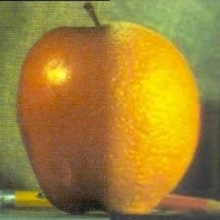

In [49]:
# blending sometimes results in slightly out of bound numbers.
outimgr[outimgr < 0] = 0
outimgr[outimgr > 255] = 255
outimgr = outimgr.astype(np.uint8)

outimgg[outimgg < 0] = 0
outimgg[outimgg > 255] = 255
outimgg = outimgg.astype(np.uint8)

outimgb[outimgb < 0] = 0
outimgb[outimgb > 255] = 255
outimgb = outimgb.astype(np.uint8)

result = np.zeros(image1.shape,dtype=image1.dtype)
tmp = []
tmp.append(outimgb)
tmp.append(outimgg)
tmp.append(outimgr)
result = cv2.merge(tmp,result)
cv2.imwrite('blended.jpg', result)
cv2_imshow(result)